In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from bs4 import BeautifulSoup

In [2]:
with open('./residents-subzone-2017.kml', 'r') as f:
    soup = BeautifulSoup(f, 'xml')

In [3]:
placemarks = [placemark for placemark in soup.find_all('Placemark')]

In [4]:
print(len(placemarks))

323


In [5]:
# reading one datapoint
sample = [
placemarks[0].get('id'),
placemarks[0].snippet,
# placemarks[0].description,
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"SUBZONE_N"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"PLN_AREA_N"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"TOTAL"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"HDB"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"ONE_TO_TWO_RM"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"THREE_RM"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"FOUR_RM"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"FIVE_RM_EXEC_FLATS"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"CONDOS_OTHER_APTS"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"LANDED_PROPERTIES"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"OTHERS"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"INC_CRC"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"FMEL_UPD_D"}),
# [[float(num) for num in pt.split(",")] 
#  for pt in placemarks[26].Polygon.outerBoundaryIs.LinearRing.text.strip().split(" ")],
# [[float(num) for num in pt.split(",")] 
#  for pt in placemarks[26].Polygon.text.strip().replace("\n\n\n\n\n", " ").split(" ")]
]
sample

['kml_1',
 <snippet> </snippet>,
 <SimpleData name="SUBZONE_N">MARINA SOUTH</SimpleData>,
 <SimpleData name="PLN_AREA_N">MARINA SOUTH</SimpleData>,
 <SimpleData name="TOTAL">0</SimpleData>,
 <SimpleData name="HDB">0</SimpleData>,
 <SimpleData name="ONE_TO_TWO_RM">0</SimpleData>,
 <SimpleData name="THREE_RM">0</SimpleData>,
 <SimpleData name="FOUR_RM">0</SimpleData>,
 <SimpleData name="FIVE_RM_EXEC_FLATS">0</SimpleData>,
 <SimpleData name="CONDOS_OTHER_APTS">0</SimpleData>,
 <SimpleData name="LANDED_PROPERTIES">0</SimpleData>,
 <SimpleData name="OTHERS">0</SimpleData>,
 <SimpleData name="INC_CRC">A414A47E5AA4EDB5</SimpleData>,
 <SimpleData name="FMEL_UPD_D">20170927160941</SimpleData>]

In [6]:
# pm.ExtendedData.decompose()
# pm.description.decompose()
# pm.text[14:].strip().split(" ")

In [7]:
placemark_data = []

for placemark in placemarks:
    val_TOTAL = int(placemark.ExtendedData.SchemaData.find("SimpleData", {"name":"TOTAL"}).text)
    val_SUBZONE_N = placemark.ExtendedData.SchemaData.find("SimpleData", {"name":"SUBZONE_N"}).text
    val_PLN_AREA_N = placemark.ExtendedData.SchemaData.find("SimpleData", {"name":"PLN_AREA_N"}).text
    placemark.ExtendedData.decompose()
    placemark.description.decompose()
    placemark_data.append([
        placemark.get('id'),
        val_TOTAL,
        val_SUBZONE_N,
        val_PLN_AREA_N,
#         [[float(num) for num in pt.split(",")] 
#          for pt in placemark.Polygon.text.strip().replace("\n\n\n\n\n", " ").split(" ")]
#         [[float(num) for num in pt.split(",")] 
#          for pt in placemark.Polygon.outerBoundaryIs.LinearRing.text.strip().split(" ")]
#         [[float(num) for num in pt.split(",")] 
#          for pt in placemark.text[14:].strip().replace("\n\n\n\n\n", " ").split(" ")]
        [[[float(num) for num in pt.split(",")] 
          for pt in ring.split(" ")] 
         for ring in placemark.text[14:].strip().split("\n\n\n\n\n")]
    ])

In [8]:
df = pd.DataFrame(placemark_data, columns=["id", "TOTAL", "SUBZONE_N", "PLN_AREA_N", "boundary"])

In [9]:
sum(df["TOTAL"])

3966030

#### Calculate the centre of district

In [10]:
def centre_boundary(boundary):
    boundary = sum(row["boundary"], [])  # flatten one level
    x_mean = sum([b[0] for b in boundary])/len(boundary)
    y_mean = sum([b[1] for b in boundary])/len(boundary)
    return x_mean, y_mean

In [11]:
df["x_centre"] = np.nan
df["y_centre"] = np.nan

In [12]:
for index, row in df.iterrows():
    x_mean, y_mean = centre_boundary(row["boundary"])
    df.at[index, "x_centre"] = x_mean
    df.at[index, "y_centre"] = y_mean

In [13]:
df.sample(5)

,id,TOTAL,SUBZONE_N,PLN_AREA_N,boundary,x_centre,y_centre
20,kml_21,1060,ALEXANDRA NORTH,BUKIT MERAH,"[[[103.817431983307, 1.29430626312647, 0.0], [...",103.820866,1.293016
120,kml_121,6010,WEST COAST,CLEMENTI,"[[[103.755785286857, 1.31970457788948, 0.0], [...",103.756935,1.315368
7,kml_8,120,CLARKE QUAY,SINGAPORE RIVER,"[[[103.845460189953, 1.28669796391714, 0.0], [...",103.844334,1.289594
125,kml_126,3600,TYERSALL,TANGLIN,"[[[103.821297879974, 1.32203490553337, 0.0], [...",103.812947,1.314700
14,kml_15,9810,KAMPONG TIONG BAHRU,BUKIT MERAH,"[[[103.823718606766, 1.28188522231965, 0.0], [...",103.826675,1.278570


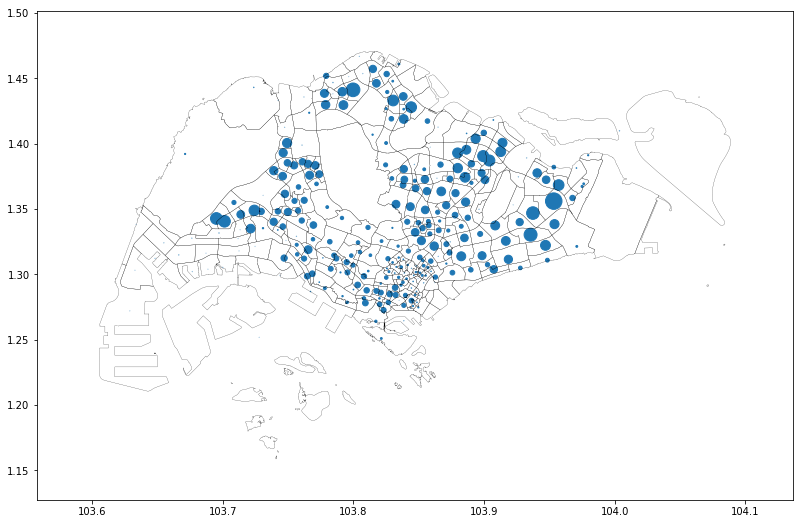

In [14]:
fig, ax = plt.subplots(figsize=(14,9))
plt.scatter(df["x_centre"], df["y_centre"], df["TOTAL"]/500)
lines = []
for rings in df["boundary"]:
    for b in rings:
        n = len(b)
        for e,_ in enumerate(b):
            lines.append([[b[e%n][0], b[e%n][1]], [b[(e+1)%n][0], b[(e+1)%n][1]]])
lc = mc.LineCollection(lines, colors="black", linewidths=0.2)
ax.add_collection(lc)
ax.autoscale()
ax.set_aspect(1)
ax.margins(0.1)
plt.show()

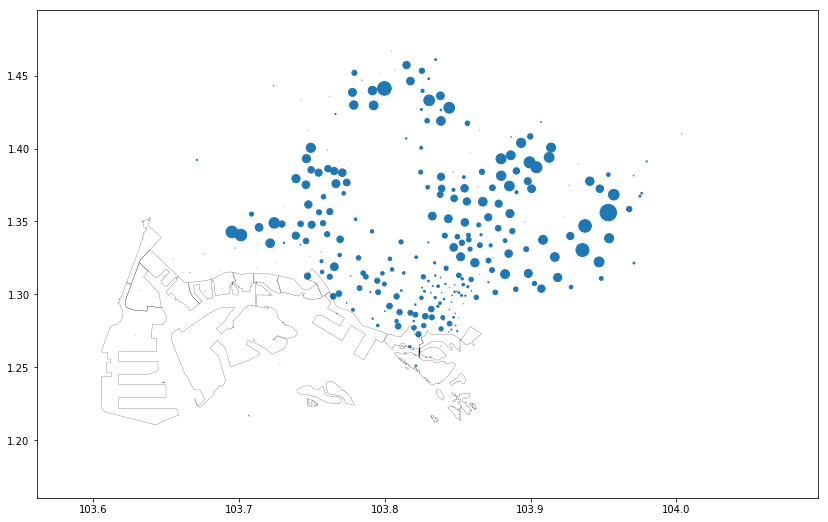

In [15]:
# probably should combine al this subzone into one
lst = [25,28,29,30,32,33,70,74,84,85,105,106,107,111,119,136,141,165]
fig, ax = plt.subplots(figsize=(14,9))
plt.scatter(df["x_centre"], df["y_centre"], df["TOTAL"]/500)
lines = []
for i,rings in enumerate(df["boundary"]):
    if i+1 not in lst:
        continue
    for b in rings:
        n = len(b)
        for e,_ in enumerate(b):
            lines.append([[b[e%n][0], b[e%n][1]], [b[(e+1)%n][0], b[(e+1)%n][1]]])
lc = mc.LineCollection(lines, colors="black", linewidths=0.2)
ax.add_collection(lc)
ax.autoscale()
ax.set_aspect(1)
ax.margins(0.1)
plt.show()

In [16]:
df["adjacent"] = [[] for x in df["id"]]

In [17]:
from collections import defaultdict

d_pts = defaultdict(set)

for index, row in df.iterrows():
    for ring in row["boundary"]:
        for pt in ring:
            d_pts[(pt[0],pt[1])].add(index)

In [18]:
for index, row in df.iterrows():
    adj_set = set()
    for ring in row["boundary"]:
        for pt in ring:
            adj_set |= d_pts[(pt[0],pt[1])]    
    df.at[index, "adjacent"] = list(adj_set)

In [19]:
df.sample(5)

,id,TOTAL,SUBZONE_N,PLN_AREA_N,boundary,x_centre,y_centre,adjacent
79,kml_80,10,MARINA CENTRE,DOWNTOWN CORE,"[[[103.863449045972, 1.29386684814145, 0.0], [...",103.862104,1.293773,"[0, 132, 43, 45, 79, 21, 94]"
263,kml_264,30,GALI BATU,SUNGEI KADUT,"[[[103.774103650599, 1.39298929466509, 0.0], [...",103.760625,1.398961,"[291, 260, 261, 263, 300, 303, 240, 274, 249, ..."
126,kml_127,8870,MOULMEIN,NOVENA,"[[[103.848520391611, 1.32203635774028, 0.0], [...",103.842022,1.317900,"[65, 101, 74, 109, 113, 182, 126]"
210,kml_211,1420,YISHUN CENTRAL,YISHUN,"[[[103.835955326142, 1.4229338523717, 0.0], [1...",103.838430,1.426509,"[320, 269, 302, 305, 210, 317]"
58,kml_59,10,INTERNATIONAL BUSINESS PARK,JURONG EAST,"[[[103.751893964519, 1.32194242650576, 0.0], [...",103.748326,1.325987,"[97, 58, 100, 176, 246, 120, 186, 191]"
